In [ ]:
from zipfile import ZipFile
import os

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
dataset_path = '/content/drive/MyDrive/ml project/bone2/bone2.zip'
output_path = '/content/drive/MyDrive/ml project/bone2'
with ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(output_path)

NameError: name 'ZipFile' is not defined

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import pathlib

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8')

In [ ]:
train_image_path = pathlib.Path(data_dir/'train/images')
train_label_path = pathlib.Path(data_dir/'train/labels')

In [ ]:
print(train_image_path)

/content/drive/MyDrive/ml project/test/train/images


In [ ]:

def get_sorted_files(image_dir, label_dir):


    train_image_path = Path(image_dir)
    train_label_path = Path(label_dir)


    image_files = sorted(train_image_path.glob('*.jpg'))


    label_files = sorted(train_label_path.glob('*.txt'))

    return image_files, label_files

def get_label(file_path):

    with open(file_path, 'r') as file:
        label_content = file.readline().strip()
        if not label_content:
            return None
        return int(label_content[0])


image_dir = '/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/train/images'
label_dir = '/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/train/labels'


image_files, label_files = get_sorted_files(image_dir, label_dir)


images = []
labels = []
IMG_SIZE = 256


for image_file, label_file in zip(image_files, label_files):

    image_path = str(image_file)
    label_path = str(label_file)


    label = get_label(label_path)
    if label is None:
        continue


    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    images.append(image)


    labels.append(label)


images = np.array(images)
labels = np.array(labels)

print(f'Loaded {len(images)} images and {len(labels)} labels.')

Loaded 1804 images and 1804 labels.


In [ ]:
from tensorflow.keras.utils import to_categorical
label_mapping = {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5}

labels_mapped = np.array([label_mapping[label] for label in labels])
labels_one_hot = to_categorical(labels_mapped, num_classes=6)

df_labels = pd.DataFrame(labels_one_hot, columns=[f'Class_{i}' for i in range(6)])

class_counts = df_labels.sum()

print("Class counts:")
print(class_counts)

Class counts:
Class_0    306.0
Class_1    433.0
Class_2    283.0
Class_3    299.0
Class_4    315.0
Class_5    168.0
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

# Ensure that `images` and `labels_mapped` are numpy arrays or similar structures
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels_mapped,
    test_size=0.2,
    stratify=labels_mapped,   # This ensures that the distribution of labels is preserved
    random_state=42           # Optionally add a random state for reproducibility
)


In [ ]:
print(labels_mapped.shape)


(1804,)


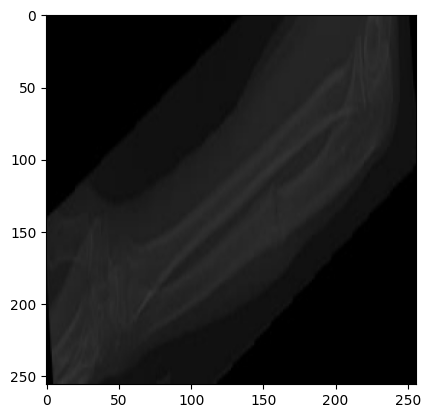

In [ ]:
plt.imshow(X_train[0])

In [ ]:
len(X_train)

1443

In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train, num_classes=6)
y_val_one_hot = to_categorical(y_val, num_classes=6)

BATCH_SIZE = 32


datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow(X_train, y_train_one_hot, batch_size=BATCH_SIZE, shuffle=True)
validation_data = datagen.flow(X_val, y_val_one_hot, batch_size=BATCH_SIZE)

print("Training set size:", len(train_data))
print("Validation set size:", len(validation_data))

print("One-hot encoded y_train shape:", y_train_one_hot.shape)
print("One-hot encoded y_val shape:", y_val_one_hot.shape)

Training set size: 46
Validation set size: 12
One-hot encoded y_train shape: (1443, 6)
One-hot encoded y_val shape: (361, 6)


In [ ]:
#to solve the overfitting increase the dropout to 0.6 and using regularizers and make the learning rate =0.0005

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

model = keras.models.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    keras.layers.Conv2D(16, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 258064)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │       1,548,390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,548,838 (5.91 MB)

 Trainable params: 1,548,838 (5.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.2483 - loss: 1.9568 - val_accuracy: 0.2909 - val_loss: 1.8744
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3890 - loss: 1.6486 - val_accuracy: 0.4155 - val_loss: 1.6715
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4988 - loss: 1.4398 - val_accuracy: 0.3934 - val_loss: 1.7352
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5453 - loss: 1.3892 - val_accuracy: 0.4875 - val_loss: 1.4344
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.5900 - loss: 1.2671 - val_accuracy: 0.5291 - val_loss: 1.3948
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6779 - loss: 1.0803 - val_accuracy: 0.5374 - val_loss: 1.3936
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6660 - loss: 1.0837 - val_accuracy: 0.5485 - val_loss: 1.3315
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7122 - loss: 0.9530 - val_accuracy: 0.5457 - val_loss: 1

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(validation_data)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6076 - loss: 1.1949
Test Loss: 1.2066277265548706
Test Accuracy: 0.6204985976219177


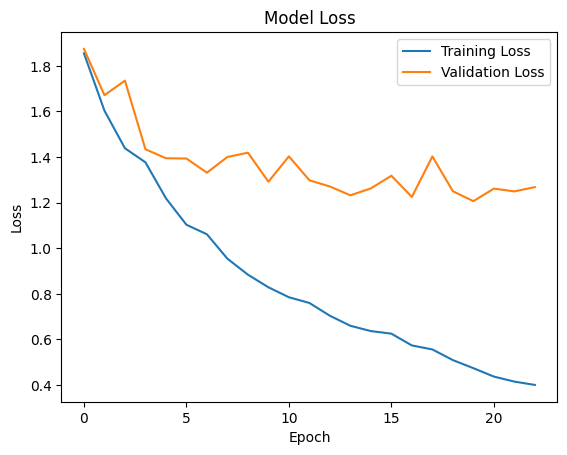

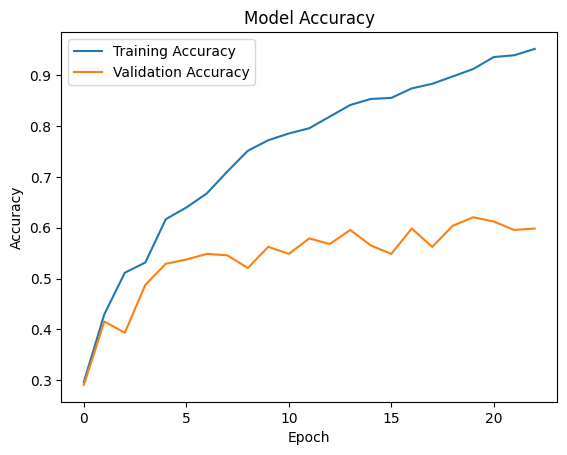

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values if accuracy was used as a metric
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted class: 4


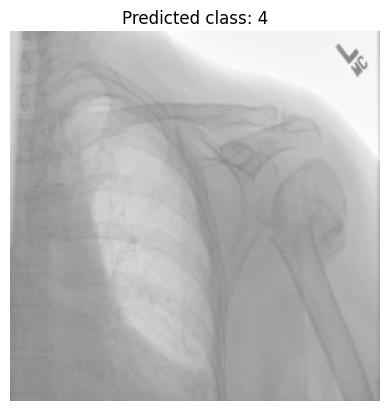

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_image(image_path, model, img_size=256):
    """
    Given an image path, the model, and an optional image size,
    this function predicts the class of the image and displays the image.
    """
    # Read the image from the given path
    img = cv2.imread('/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/test/images/image2_698_png.rf.66b6d614653eed2ef4e81695aca5c5a6.jpg')

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Resize the image to match the model's expected input size
    img = cv2.resize(img, (img_size, img_size))  # Resize image to the input size for the model

    # Preprocess the image (normalize and expand dimensions)
    img = img / 255.0  # Normalize the image if rescaling was done during training
    img = np.expand_dims(img, axis=0)  # Add a batch dimension

    # Convert to uint8 for visualization
    img_display = np.uint8(img[0] * 255)  # Convert back to uint8 for correct visualization

    # Predict the class of the image using the model
    prediction = model.predict(img)

    # Get the predicted class (index of the max probability)
    predicted_class = np.argmax(prediction)

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

    # Display the image with the predicted class
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example of predicting an image from the validation set
image_path = '/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/test/images/image1_0_png.rf.99862308d714bff3f9c410adf5ca93ac.jpg'  # Path to the image you want to predict
predict_image(image_path, model)  # Call the function with the model and image


In [ ]:
# Save the trained model
model.save('bone_fracture_detection_model.h5')  # Saves the model in HDF5 format
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/sample_data/bone_fracture_detection_model.h5')
print("Model loaded successfully!")

Model loaded successfully!


new test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Predicted class: 3


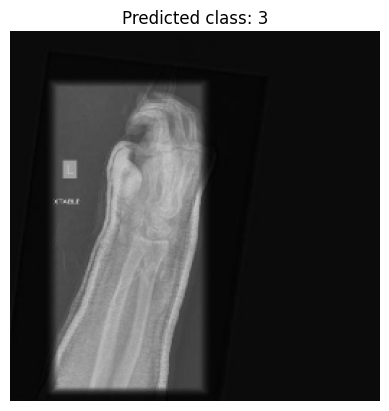

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def predict_image(image_path, model, img_size=256):
    """
    Given an image path, the model, and an optional image size,
    this function predicts the class of the image and displays the image.
    """
    # Read the image from the given path
    img = cv2.imread('/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/test/images/image1_1057_png.rf.dbd0e857728d8b149e5732cb2824d819.jpg')

    # Check if the image was loaded successfully
    if img is None:
        print(f"Error: Unable to load image from {image_path}")
        return

    # Resize the image to match the model's expected input size
    img = cv2.resize(img, (img_size, img_size))  # Resize image to the input size for the model

    # Preprocess the image (normalize and expand dimensions)
    img = img / 255.0  # Normalize the image if rescaling was done during training
    img = np.expand_dims(img, axis=0)  # Add a batch dimension

    # Convert to uint8 for visualization
    img_display = np.uint8(img[0] * 255)  # Convert back to uint8 for correct visualization

    # Predict the class of the image using the model
    prediction = model.predict(img)

    # Get the predicted class (index of the max probability)
    predicted_class = np.argmax(prediction)

    # Print the predicted class
    print(f"Predicted class: {predicted_class}")

    # Display the image with the predicted class
    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.title(f"Predicted class: {predicted_class}")
    plt.axis('off')  # Turn off axis labels
    plt.show()

# Example of predicting an image from the validation set
image_path = '/content/drive/MyDrive/ml project/bone2/BoneFractureYolo8/test/images/image1_0_png.rf.99862308d714bff3f9c410adf5ca93ac.jpg'  # Path to the image you want to predict
predict_image(image_path, model)  # Call the function with the model and image
